In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Any, List, Tuple, Set, Dict, Iterator, Iterable, Generator
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from enum import Enum

In [2]:
class Model(Enum):
    BASIC = 1
    GAZELLE_CAP = 2
    HOLLING_TYPE = 3
    POACHERS = 4

In [3]:
def gazelle_pop(x: float, y: float, z: float, a: float, b: float, c: float): 
    return x * (a - (b * y) - (c * z))
    
def crocodile_pop(x: float, y: float, z: float, d: float, e: float, f: float): 
    return y * (d * x - e - f * z)
    
def lion_pop(x: float, y: float, z: float, g: float, h: float, k: float): 
    return z * (g * x - h * y - k)

In [4]:
def gazelle_pop_cap(x: float, y: float, z: float, a: float, b: float, c: float, M: float):
    return x * (a * (1 - (x / M) - (b * y) - (c * z)))

In [5]:
def gazelle_pop_holling(x: float, y: float, z: float, a: float, b: float, c: float, M: float): 
    return x * (a * (1 - (x / M) - ((b * y) + (c * z)) / (1 + (a * x))))
    
def crocodile_pop_holling(x: float, y: float, z: float, a: float, b: float, d: float, e: float, f: float): 
    return y * ((d * b * x) / (1 + (a * x)) - e - (b * z) / (1 + y))
    
def lion_pop_holling(x: float, y: float, z: float, a: float, c: float, f: float, g: float, h: float, k: float): 
    return z * ((g * c * x) / (1 + (a * x)) + ( h * f * z) / (1 + y) - k)

In [6]:
def lion_pop_poachers(x: float, y: float, z: float, a: float, c: float, f: float, g: float, h: float, k: float, q: float, E: float, m1: float, m2: float) -> float:
        return z * ((g * c * x) / (1 + a * x) + (h * f * z) / (1 + y) - k - (q * E* z) / (m1 * E + m2 * z))

In [7]:
def population(model: Model, u_t: List[float], a: float, b: float, c: float, d: float, e: float, f: float, g: float, h: float, k: float, M: float = 0, q: float = 0, E: float = 0, m1: float = 0, m2: float = 0):
    '''Defines the Lotka-Volterra model 
    for different values of y. '''
        
    x = u_t[0]
    y = u_t[1]
    z = u_t[2]
    
    N = np.zeros(len(u_t))
    
    if model == Model.BASIC:
        N[0] = gazelle_pop(x, y, z, a, b, c)
        N[1] = crocodile_pop(x, y, z, d, e, f)
        N[2] = lion_pop(x, y, z, g, h, k)
    elif model == Model.GAZELLE_CAP:
        N[0] = gazelle_pop_cap(x, y, z, a, b, c, M)
        N[1] = crocodile_pop(x, y, z, d, e, f)
        N[2] = lion_pop(x, y, z, g, h, k)
    elif model == Model.HOLLING_TYPE:
        assert c*g*h - b*f*g != 0, "We assume cdh - bfg != 0" 
        N[0] = gazelle_pop_holling(x, y, z, a, b, c, M)
        N[1] = crocodile_pop_holling(x, y, z, a, b, d, e, f)
        N[2] = lion_pop_holling(x, y, z, a, c, f, g, h, k)
    elif model == Model.POACHERS:
        assert c*g*h - b*f*g != 0, "We assume cdh - bfg != 0" 
        N[0] = gazelle_pop_holling(x, y, z, a, b, c, M)
        N[1] = crocodile_pop_holling(x, y, z, a, b, d, e, f)
        N[2] = lion_pop_poachers(x, y, z, a, c, f, g, h, k, q, E, m1, m2) 
        
    return N

In [8]:
def RungeKutta(model: Model, y: List[float], a: float, b: float, c: float, d: float, e:float, f: float, g: float, h: float, k: float, dt: float, M: float = 0, q: float = 0, E: float = 0, m1: float = 0, m2: float = 0) -> float:
    '''Implements the RungeKutta method to 
    approximate the solution of a differential equation.'''
    
    l = y.size;
    
    c1 = np.zeros(l)
    c2 = np.zeros(l)
    c3 = np.zeros(l)
    c4 = np.zeros(l)
    
    c1 = population(model, y, a, b, c, d, e, f, g, h, k, M)
    c2 = y + dt*c1/2.0;
    c2 = population(model, c2, a, b, c, d, e, f, g, h, k, M)
    c3 = y + dt*c2/2.0;
    c3 = population(model, c3, a, b, c, d, e, f, g, h, k, M)
    c4 = y + dt*c3;
    c4 = population(model, c4, a, b, c, d, e, f, g, h, k, M)

    result = y + dt*(c1 + 2*(c2 + c3) + c4)/6

    
    return result 

In [9]:
def solve_pop(model: Model, a: float, b: float, c: float, d: float, e:float, f: float, g: float, h: float, k: float, initial_1: float, initial_2: float, initial_3: float, M: float = 0, q: float = 0, E: float = 0, m1: float = 0, m2: float = 0, n: float = 10000):
    '''Shows plots from various perspectives for different 
    constants in the Lotka-Volterra model and different 
    initial values of the differential equations.'''
    
    n = 10000
    
    y1 = np.zeros(n + 1)
    y2 = np.zeros(n + 1)
    y3 = np.zeros(n + 1)
    y = np.zeros(3)
    
    dt = 0.05
    
    y1[0] = y[0] = initial_1;
    y2[0] = y[1] = initial_2;
    y3[0] = y[2] = initial_3;
    
    time = [0]
        
    for i in range(0, n):
        t = dt * i
        y = RungeKutta(model, y, a, b, c, d, e, f, g, h, k, dt, M)
        
        time.append(t)
        
        y1[i + 1] = y[0]
        y2[i + 1] = y[1]
        y3[i + 1] = y[2]
    
    
    fig, ax = plt.subplots(nrows = 2, ncols = 2, squeeze = False, figsize = (15, 6))
    
    ax[0, 0].plot(time, y1, label = "Gazelles")
    ax[0, 0].plot(time, y2, label = "Crocodiles")
    ax[0, 0].plot(time, y3, label = "Lions")
    ax[0, 0].set_xlabel('time')
    ax[0, 0].set_ylabel('population')
    ax[0, 0].grid()
    ax[0, 0].legend()
    ax[0, 1].plot(y1, y2, '.')
    ax[0, 1].set_xlabel('Gazelle')
    ax[0, 1].set_ylabel('Crocodile')
    ax[0, 1].grid()
    ax[1, 0].plot(y2, y3, '.')
    ax[1, 0].set_xlabel('Crocodile')
    ax[1, 0].set_ylabel('Lion')
    ax[1, 0].grid()
    ax[1, 1].plot(y3, y1, '.')
    ax[1, 1].set_xlabel('Lion')
    ax[1, 1].set_ylabel('Gazelle')
    ax[1, 1].grid()
    
    
    plt.show()    

In [10]:
def solve_pop3d(model: Model, a: float, b: float, c: float, d: float, e:float, f: float, g: float, h: float, k: float, initial_1: float, initial_2: float, initial_3: float, M: float = 0, q: float = 0, E: float = 0, m1: float = 0, m2: float = 0, n: float = 10000):
    '''Shows plots from various perspectives for different 
    constants in the Lotka-Volterra model and different 
    initial values of the differential equations.'''
        
    y1 = np.zeros(n + 1)
    y2 = np.zeros(n + 1)
    y3 = np.zeros(n + 1)
    y = np.zeros(3)
    
    dt = 0.05
    
    y1[0] = y[0] = initial_1;
    y2[0] = y[1] = initial_2;
    y3[0] = y[2] = initial_3;
        
    time = [0]
    
    for i in range(0, n):
        t = dt * i
        y = RungeKutta(model, y, a, b, c, d, e, f, g, h, k, dt, M)
                
        time.append(t)
        
        y1[i + 1] = y[0]
        y2[i + 1] = y[1]
        y3[i + 1] = y[2]
    
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(y1, y2, y3)
    ax.set_xlabel('Gazelle')
    ax.set_ylabel('Crocodile')
    ax.set_zlabel('Lion', rotation=90)
    ax.set_title('Three species')
    
    plt.tight_layout()
    plt.show()   

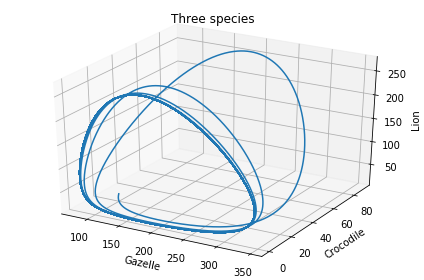

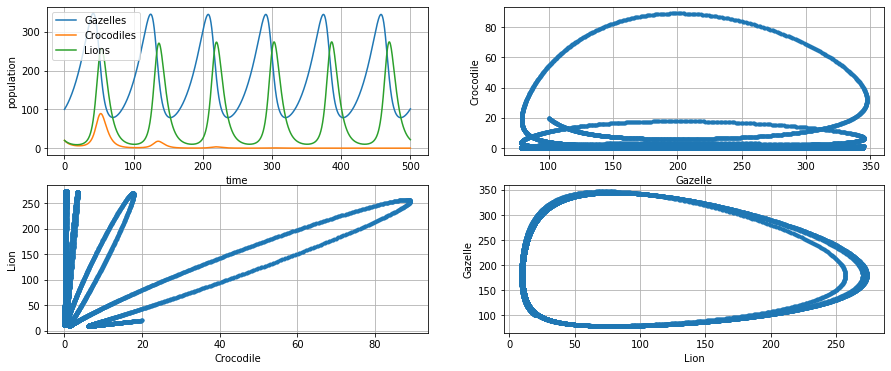

In [16]:
model = Model.BASIC

n = 100000

M = 1000
q = 5
E = 3
m1 = 1
m2 = 1

initial_gazelle = 100
initial_crocodile = 20
initial_lion = 20

a = 0.04
b = 0.0001
c = 0.0005
d = 0.001
e = 0.2
f= 0
g = 0.001
h = 0
k = 0.18


solve_pop3d(model=model, a=a, b=b, c=c, d=d, e=e, f=f, g=g, h=h, k=k, initial_1=initial_gazelle, initial_2=initial_crocodile, initial_3=initial_lion, M=M, q=q, E=E, m1=m1,m2=m2, n=n)
solve_pop(model=model, a=a, b=b, c=c, d=d, e=e, f=f, g=g, h=h, k=k, initial_1=initial_gazelle, initial_2=initial_crocodile, initial_3=initial_lion, M=M, q=q, E=E, m1=m1, m2=m2, n=n)